In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


In [2]:
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
import glob
from skimage.io import imread
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np 
import os
from keras import backend as K
from sklearn.cluster import MiniBatchKMeans,KMeans
from collections import Counter
from sklearn.decomposition import PCA
import lda
import time
#%%
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from function import newtxt,newimagedata,create_plots,plot_confusion_matrix,cnn_model,cnn_model1,cnn_model2

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np 
import os
from keras.utils.vis_utils import plot_model
from sklearn.decomposition import PCA

Using TensorFlow backend.


In [3]:
count = 0
all_divide_image = np.zeros([1,32,32,3])
read_files = glob.glob("./2012raw_data/*.txt")
for name in read_files:
    name = name.split("/")[2]
    name = name.split(".")[0]
    path_image = str('./2012image/')+name+str('.jpg')
    single_img = imread(path_image)
    divide_image = np.zeros([3072,32,32,3])
    count_patch = 0
    for i in range(64):
        for j in range(48):
            divide_image[count_patch,:,:,:] = single_img[j*32:(j+1)*32,i*32:(i+1)*32]
            count_patch = count_patch + 1
    all_divide_image = np.vstack((all_divide_image,divide_image))
    count = count + 1
    print("---image %d finished" % (count))

---image 1 finished
---image 2 finished
---image 3 finished
---image 4 finished
---image 5 finished
---image 6 finished
---image 7 finished
---image 8 finished
---image 9 finished
---image 10 finished
---image 11 finished
---image 12 finished
---image 13 finished
---image 14 finished
---image 15 finished
---image 16 finished
---image 17 finished
---image 18 finished
---image 19 finished
---image 20 finished
---image 21 finished
---image 22 finished
---image 23 finished
---image 24 finished
---image 25 finished
---image 26 finished
---image 27 finished
---image 28 finished
---image 29 finished
---image 30 finished
---image 31 finished
---image 32 finished
---image 33 finished
---image 34 finished
---image 35 finished
---image 36 finished
---image 37 finished
---image 38 finished
---image 39 finished
---image 40 finished
---image 41 finished
---image 42 finished
---image 43 finished
---image 44 finished
---image 45 finished
---image 46 finished
---image 47 finished
---image 48 finished
-

In [4]:
all_divide_image = all_divide_image[1:]

In [5]:
num = all_divide_image.shape[0]
all_divide_image = all_divide_image.reshape(num,3072)

In [6]:
import random
random.shuffle(all_divide_image)

In [8]:
all_divide_image = all_divide_image.reshape(num,32,32,3)
all_divide_image.shape

(368640, 32, 32, 3)

In [9]:
batch_size = 128
num_classes = 10
epochs = 100
x_train = all_divide_image[0:300000]
x_test = all_divide_image[300000:]

In [10]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (300000, 32, 32, 3)
300000 train samples
68640 test samples


In [10]:
from keras.layers import Input,BatchNormalization,UpSampling2D
from keras.models import load_model,Model

In [24]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [25]:
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='binary_crossentropy')

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_11 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 32)        18464     
_________________________________________________________________
batch_normalization_11 (Batc (None, 16, 16, 32)        128       
__________

In [27]:
x_val = x_test[:20000]
x_test = x_test[20000:]
print("validation data: {0} \ntest data: {1}".format(x_val.shape, x_test.shape))

validation data: (20000, 32, 32, 3) 
test data: (28640, 32, 32, 3)


In [15]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = 'AutoEncoder_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [16]:
history = model.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, x_val),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

Train on 300000 samples, validate on 20000 samples
Epoch 1/100
300000/300000 [==============================] - 179s 598us/step - loss: 0.5481 - val_loss: 0.5411

Epoch 00001: val_loss improved from inf to 0.54112, saving model to AutoEncoder_weights.01-0.55-0.54.hdf5
Epoch 2/100
300000/300000 [==============================] - 178s 593us/step - loss: 0.5405 - val_loss: 0.5378

Epoch 00002: val_loss improved from 0.54112 to 0.53780, saving model to AutoEncoder_weights.02-0.54-0.54.hdf5
Epoch 3/100
300000/300000 [==============================] - 178s 593us/step - loss: 0.5390 - val_loss: 0.5364

Epoch 00003: val_loss improved from 0.53780 to 0.53645, saving model to AutoEncoder_weights.03-0.54-0.54.hdf5
Epoch 4/100
300000/300000 [==============================] - 178s 592us/step - loss: 0.5383 - val_loss: 0.5352

Epoch 00004: val_loss improved from 0.53645 to 0.53521, saving model to AutoEncoder_weights.04-0.54-0.54.hdf5
Epoch 5/100
300000/300000 [==============================] - 178s

In [33]:
# load pretrained weights
model.load_weights("AutoEncoder_weights.07-0.53-0.53.hdf5")

In [75]:
from keras import backend as K
bottom_output = K.function([model.layers[0].input],[model.layers[15].output])

In [74]:
model.layers[15]

In [40]:
# definition to show original image and reconstructed image
def showOrigDec(orig, dec, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [41]:
c10test = model.predict(x_test,verbose=1)
c10val = model.predict(x_val,verbose=1)

20000/20000 [==============================] - 5s 268us/step


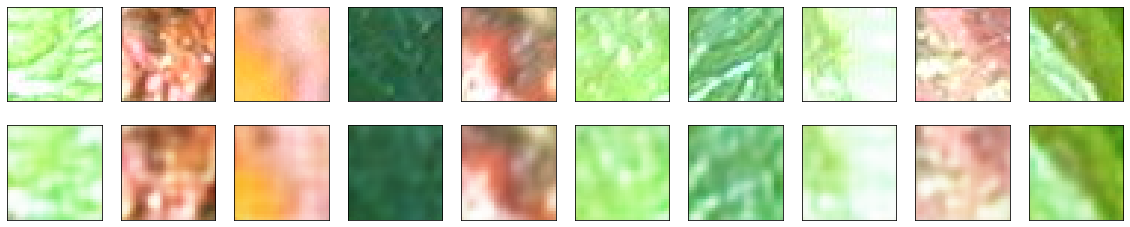

In [42]:
showOrigDec(x_test[300:400], c10test[300:400])

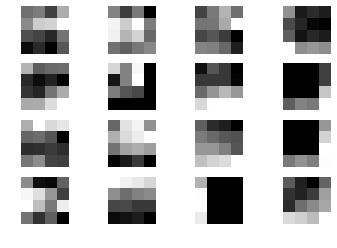

In [76]:
sample_image = all_divide_image[40:41]/255
sample_output = bottom_output([sample_image])[0]

show_layer = sample_output[0]
for _ in range(16):            
    show_img = sample_output[:, :, :, _]            
    show_img.shape = [4, 4]            
    plt.subplot(4, 4, _ + 1)            
    plt.imshow(show_img, cmap='gray')            
    plt.axis('off')
plt.show()

In [77]:
print(sample_output)

[[[[1.9857111  1.6339027  0.94079477 1.5565308  1.580227   0.47068578
    0.8337424  0.         1.5704162  1.4178089  1.1275656  0.
    1.5939922  2.882517   0.894888   1.1984956 ]
   [2.0358796  1.4823725  1.1484934  0.9289593  1.2114043  0.28406847
    1.2464414  0.         1.8201904  2.0265512  0.9606834  0.
    1.2188723  2.7568705  0.         0.9252934 ]
   [1.8112291  1.6131809  1.3736529  1.0266845  1.2644186  0.54242176
    1.0735908  0.         1.7034779  2.1186287  0.9197316  0.
    1.1981108  2.683935   0.         0.7766663 ]
   [2.2192152  1.3535615  1.1158739  0.94325686 1.2760353  0.
    0.72789156 0.434237   1.7431629  1.6279998  0.82397324 0.6732005
    1.4631839  2.5229151  0.         1.242239  ]]

  [[2.0895662  1.8681779  1.1270981  1.1890805  0.983957   0.04665911
    1.0688564  0.         1.3452318  1.783352   1.2095517  0.
    1.9168601  1.9137464  1.2741479  1.0168922 ]
   [2.3427677  1.7869272  1.1367818  0.9913004  0.86268985 0.2866761
    1.0756522  0.        

In [24]:
import lda

In [25]:
c10test.shape

(48640, 32, 32, 3)

In [78]:
all_output = np.zeros([1,256])
for i in range(120):
    once_image = all_divide_image[i*3072:(i+1)*3072]/255
    once_output = bottom_output([once_image])[0]
    once_output = once_output.reshape(3072,256)
    all_output = np.vstack((all_output,once_output))
    print("---image %d finished" %(i))

---image 0 finished
---image 1 finished
---image 2 finished
---image 3 finished
---image 4 finished
---image 5 finished
---image 6 finished
---image 7 finished
---image 8 finished
---image 9 finished
---image 10 finished
---image 11 finished
---image 12 finished
---image 13 finished
---image 14 finished
---image 15 finished
---image 16 finished
---image 17 finished
---image 18 finished
---image 19 finished
---image 20 finished
---image 21 finished
---image 22 finished
---image 23 finished
---image 24 finished
---image 25 finished
---image 26 finished
---image 27 finished
---image 28 finished
---image 29 finished
---image 30 finished
---image 31 finished
---image 32 finished
---image 33 finished
---image 34 finished
---image 35 finished
---image 36 finished
---image 37 finished
---image 38 finished
---image 39 finished
---image 40 finished
---image 41 finished
---image 42 finished
---image 43 finished
---image 44 finished
---image 45 finished
---image 46 finished
---image 47 finished
--

In [79]:
all_output = all_output[1:]

In [82]:
pca = PCA(n_components=16)
pca.fit(all_output)
print(pca.explained_variance_ratio_)
all_output_reduced = pca.transform(all_output)


[0.48472245 0.09049576 0.06877631 0.03013542 0.02132451 0.018883
 0.01106051 0.00929812 0.00836733 0.00736714 0.00650612 0.00571886
 0.00518994 0.0050513  0.00477013 0.0045404 ]


In [83]:
all_output_reduced.shape

(368640, 16)

In [84]:
from sklearn.cluster import MiniBatchKMeans,KMeans
kmeans = MiniBatchKMeans(n_clusters=500,
        random_state=0,
        batch_size=50000,
        max_iter=50).fit(all_output_reduced)

In [85]:
code_book = kmeans.cluster_centers_
d = kmeans.predict(all_output_reduced) 

In [86]:
all_frequence = np.zeros([120,500])
for j in range(120):
    label_image = d[j*3072:(j+1)*3072]
    k = label_image.tolist()
    h = Counter(k)
    frequence_image = np.zeros(500)
    for i in range(500):
        frequence_image[i] = h[i]
    all_frequence[j] = frequence_image
    print("---image %d finished" % (j))

---image 0 finished
---image 1 finished
---image 2 finished
---image 3 finished
---image 4 finished
---image 5 finished
---image 6 finished
---image 7 finished
---image 8 finished
---image 9 finished
---image 10 finished
---image 11 finished
---image 12 finished
---image 13 finished
---image 14 finished
---image 15 finished
---image 16 finished
---image 17 finished
---image 18 finished
---image 19 finished
---image 20 finished
---image 21 finished
---image 22 finished
---image 23 finished
---image 24 finished
---image 25 finished
---image 26 finished
---image 27 finished
---image 28 finished
---image 29 finished
---image 30 finished
---image 31 finished
---image 32 finished
---image 33 finished
---image 34 finished
---image 35 finished
---image 36 finished
---image 37 finished
---image 38 finished
---image 39 finished
---image 40 finished
---image 41 finished
---image 42 finished
---image 43 finished
---image 44 finished
---image 45 finished
---image 46 finished
---image 47 finished
--

In [87]:
all_frequence[1]

array([ 7.,  3., 16.,  5.,  7.,  2.,  3., 12.,  6., 18.,  6.,  2., 34.,
        0.,  6., 14.,  1.,  8.,  4., 10., 10., 11.,  2.,  5.,  7.,  5.,
        8., 53.,  2.,  5.,  4.,  0.,  2.,  9., 15.,  6.,  5.,  9.,  0.,
       10.,  5.,  6.,  9.,  4.,  7.,  5.,  0., 12.,  1.,  5.,  3.,  9.,
        6.,  1., 13.,  3.,  1.,  0.,  4.,  8.,  5.,  0.,  1.,  1.,  2.,
        5., 10., 12.,  3., 11., 22.,  4.,  6.,  4.,  6.,  3.,  7.,  5.,
        1.,  5., 15.,  8.,  9.,  3.,  4.,  2.,  4.,  8.,  5.,  3.,  2.,
        0., 17., 17.,  1.,  0., 22.,  3.,  3.,  6.,  3.,  4.,  7., 19.,
        4., 16.,  6.,  3.,  8.,  1.,  1.,  0.,  3.,  5., 11.,  7.,  6.,
        3., 16.,  2.,  1.,  4.,  8.,  4.,  5.,  2.,  4.,  8.,  5., 19.,
        6., 12.,  3.,  6.,  1., 33.,  7.,  7.,  1.,  3., 10.,  9., 15.,
        5., 10.,  2.,  3.,  3.,  1.,  5.,  5.,  5.,  3.,  4.,  4.,  3.,
        3.,  1.,  5.,  7.,  7.,  9.,  7.,  8.,  1.,  1., 11.,  1.,  5.,
        7.,  3., 13., 24., 19.,  7.,  5.,  0.,  4., 11., 19.,  7

In [89]:
import lda
all_frequence = all_frequence.astype(np.int32)
model = lda.LDA(n_topics=5, n_iter=1000, random_state=1)
model.fit(all_frequence)

INFO:lda:n_documents: 120
INFO:lda:vocab_size: 500
INFO:lda:n_words: 368640
INFO:lda:n_topics: 5
INFO:lda:n_iter: 1000
INFO:lda:<0> log likelihood: -2817499
INFO:lda:<10> log likelihood: -2771585
INFO:lda:<20> log likelihood: -2726089
INFO:lda:<30> log likelihood: -2685768
INFO:lda:<40> log likelihood: -2653097
INFO:lda:<50> log likelihood: -2628618
INFO:lda:<60> log likelihood: -2606775
INFO:lda:<70> log likelihood: -2590170
INFO:lda:<80> log likelihood: -2576399
INFO:lda:<90> log likelihood: -2563652
INFO:lda:<100> log likelihood: -2551115
INFO:lda:<110> log likelihood: -2540155
INFO:lda:<120> log likelihood: -2530780
INFO:lda:<130> log likelihood: -2521262
INFO:lda:<140> log likelihood: -2514518
INFO:lda:<150> log likelihood: -2508958
INFO:lda:<160> log likelihood: -2502107
INFO:lda:<170> log likelihood: -2500311
INFO:lda:<180> log likelihood: -2495474
INFO:lda:<190> log likelihood: -2491931
INFO:lda:<200> log likelihood: -2486179
INFO:lda:<210> log likelihood: -2481240
INFO:lda:<22

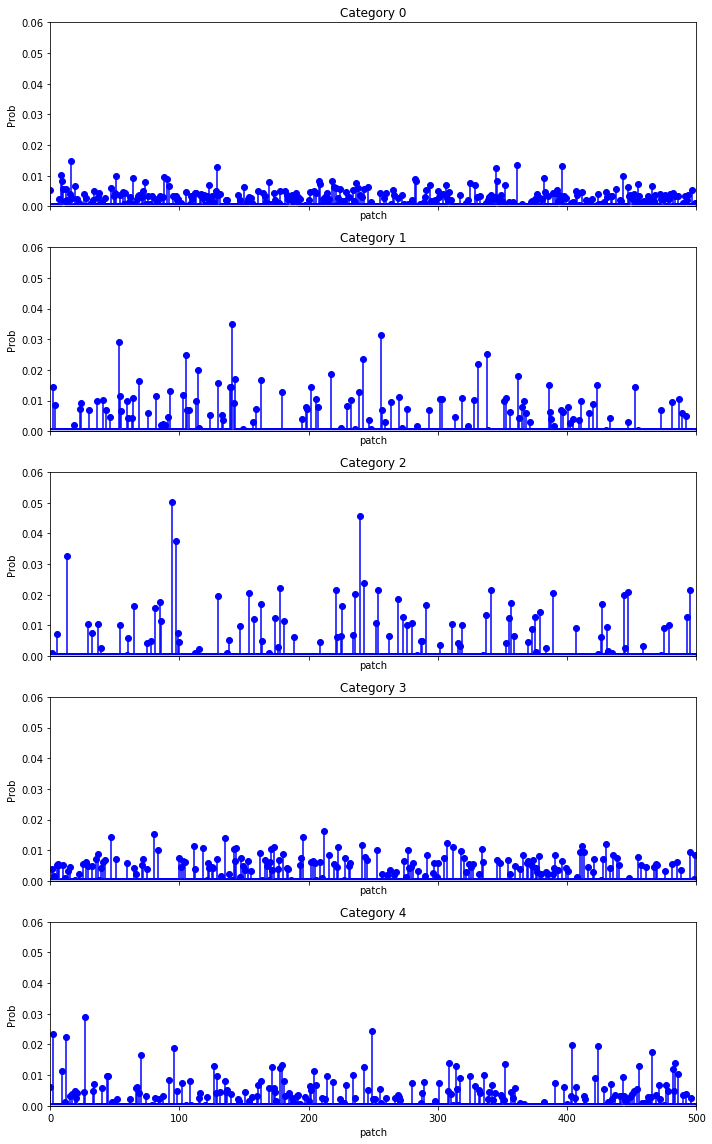

In [90]:
topic_word = model.topic_word_
f, ax= plt.subplots(5, 1, figsize=(10, 16), sharex=True)
for i, k in enumerate([0, 1, 2, 3,4]):
    ax[i].stem(topic_word[k,:], linefmt='b-',
               markerfmt='bo', basefmt='w-')
    ax[i].set_xlim(0,500)
    ax[i].set_ylim(0, 0.06)
    ax[i].set_ylabel("Prob")
    ax[i].set_title("Category {}".format(k))
    ax[i].set_xlabel("patch")
plt.tight_layout()
plt.show()

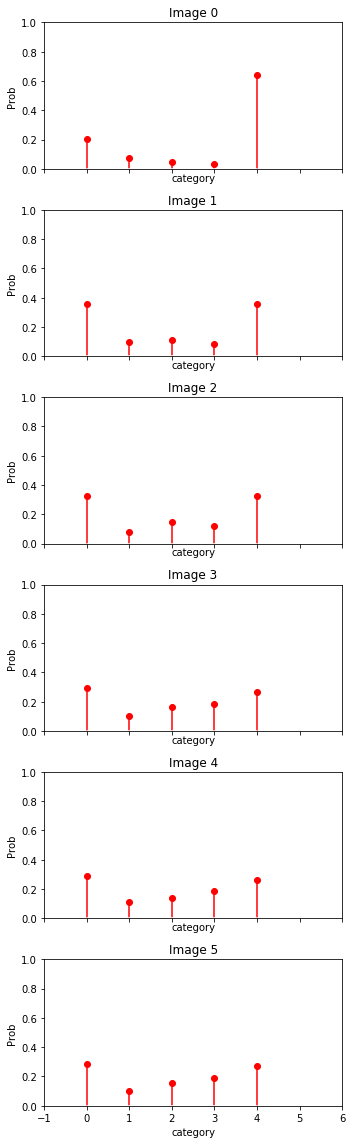

In [38]:
doc_topic = model.doc_topic_
f, ax= plt.subplots(6, 1, figsize=(5, 16), sharex=True)
for i, k in enumerate([0, 1, 2, 3, 4,5]):
    ax[i].stem(doc_topic[k,:], linefmt='r-',
               markerfmt='ro', basefmt='w-')
    ax[i].set_xlim(-1, 6)
    ax[i].set_ylim(0, 1)
    ax[i].set_ylabel("Prob")
    ax[i].set_title("Image {}".format(k))
    ax[i].set_xlabel("category")
    
plt.tight_layout()

plt.show()

In [91]:
#%% LDA model
def LDA_output(input_patch):
    #get the output of bottom layer of autoencoder
    autoencoder_feature = bottom_output([input_patch])[0]
    autoencoder_feature = autoencoder_feature.reshape(1,256)
    #PCA
    feature_reduced = pca.transform(autoencoder_feature)
    #find the center in the codebook
    
    code_center = int(kmeans.predict(feature_reduced))
    #find the category of input
    category = np.argmax(topic_word[:,code_center])
    return category

In [92]:
def percent_coral(testimage):
    count = 0
    #blue = np.array([0,0,255], dtype=np.uint8)
    test = np.uint8(testimage)
    pixel = np.zeros([1,1,3],dtype = np.uint8)
    for r in range(0,test.shape[0]):
        for c in range(0,test.shape[1]):
            pixel = test[r,c,:]
            #if(np.all(pixel == blue)):
            if((pixel[0]==0)and(pixel[1]==0)):
                count = count +1
    all_pixel = test.shape[0]*test.shape[1]
    coral_percent = (count/all_pixel)*100 
    coral_percent = round(coral_percent,2)
    return coral_percent 

In [94]:
windowsize_r = 32
windowsize_c = 32
image_path = ("./2012image/201208172_T-12-58-58_Dive_01_041.jpg")
#image_files  = glob.glob("./test_image/*")
count = 0
testimage = Image.new('RGB', (2048,1536))
test_image = imread(image_path)
start_time = time.time()
for r in range(0,test_image.shape[0] - windowsize_r+1, 6):
    for c in range(0,test_image.shape[1] - windowsize_c+1, 6):
        window = test_image[r:r+windowsize_r,c:c+windowsize_c]
        window  = window/255
        window = window.reshape(-1,32,32,3)
        y_pred = LDA_output(window)
        if(y_pred==0):#CCA---red
            testimage.paste((0,0,255),[c,r,c+windowsize_c,r+windowsize_r])
        elif(y_pred==1):#coral---blue
            testimage.paste((169,169,169),[c,r,c+windowsize_c,r+windowsize_r])
        elif(y_pred==2):#ROC---deep gray
            testimage.paste((255,0,0),[c,r,c+windowsize_c,r+windowsize_r])
        elif(y_pred==3):#Ana---green
            testimage.paste((255,255,0),[c,r,c+windowsize_c,r+windowsize_r])
        #elif(y_pred==4):#DCP---slight gray
            #testimage.paste((105,105,105),[c,r,c+windowsize_c,r+windowsize_r])
        else:#others---yellow
            testimage.paste((0,255,0),[c,r,c+windowsize_c,r+windowsize_r])
count = count+1
percent = percent_coral(testimage)
testimage.save('./result/'+'result'+str(percent)+'.jpg')
print(("---image%d finished in %s seconds ---" % (count,(time.time()-start_time))))
print("there are {0}% coral in this image".format(percent))

---image1 finished in 200.3858392238617 seconds ---
there are 34.99% coral in this image
